In [2]:
import os
import numpy as np
import cv2 as cv
from PIL import Image, ImageEnhance
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms,models
import torch.backends.cudnn as cudnn
import matplotlib .pyplot as plt
from itertools import permutations
from sklearn.model_selection import train_test_split
import math
from scipy.stats import gamma



def rotate(x, degree):
    # Rotate the image by degrees counter clockwise
    return x.rotate(degree)

def enh_bri(x, brightness):
    bri = ImageEnhance.Brightness(x)
    return bri.enhance(brightness)

def enh_con(x, contrast):
    con = ImageEnhance.Contrast(x)
    return con.enhance(contrast)

def enh_sha(x, sharpness):
    sha = ImageEnhance.Sharpness(x)
    return sha.enhance(sharpness)

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.GaussianBlur(x, kernel_size, sigmaX=0)
    return Image.fromarray(x)

def shear(x, shear_factor):
    # 定义错切变换矩阵
    shear_matrix = [1, shear_factor, 0, 0, 1, 0]

    # 创建Affine对象并应用错切变换
    sheared_img = x.transform(
        x.size, Image.Transform.AFFINE, shear_matrix
    )
    return sheared_img

def translate(x, shift):
    shift_x, shift_y = shift[0], shift[1]
    # 进行平移操作
    translated_img = x.transform(
        x.size, Image.Transform.AFFINE, (1, 0, shift_x, 0, 1, shift_y)
    )
    return translated_img

mrs = [rotate, enh_bri, enh_sha, enh_con, gaussian, shear, translate]
mrs_name =[mr.__name__ for mr in mrs]
print(mrs_name)
paras = [3, 0.8, 0.8, 0.8, (3, 3), 0.1, (1,1)]

class CustomDataset(Dataset):
    def __init__(self, dataset, cmr=None, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(dataset):
            if cmr is not None:
                for index in cmr:
                    img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, label = self.data[idx], self.labels[idx]
        if self.transform is not None:
            data = self.transform(data)
        return data, label


['rotate', 'enh_bri', 'enh_sha', 'enh_con', 'gaussian', 'shear', 'translate']


In [2]:
from torch.utils.data.dataloader import default_collate

img_dim = 128
epochs = 50
batch_size = 128
lr = 1e-3
input_size = 3 * 128 * 128
latent_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((img_dim, img_dim)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()])

def custom_collate(batch):
    inputs = [item[0] for item in batch]
    return default_collate(inputs)

train_set = datasets.VOCDetection('data/VOC', year="2007", image_set='trainval', transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

test_set = datasets.VOCDetection('data/VOC', year="2007", image_set='test', transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)


In [3]:
class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        pad_h = self.calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            Conv2dSame(3, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            Conv2dSame(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            Conv2dSame(128, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*(img_dim//8)*(img_dim//8), latent_size * 2)  # 输出均值和方差
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128*(img_dim//8)*(img_dim//8)),
            nn.ReLU(),
            nn.Unflatten(1, (128, img_dim//8, img_dim//8)),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # 编码
        latent_params = self.encoder(x)
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        z = self.reparameterize(mu, logvar)

        # 解码
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


In [4]:
model = VAE(latent_size=latent_size).to(device)

In [74]:
# 训练VAE模型

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='mean')
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        MSE = criterion(recon_batch, data)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = MSE + KLD
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader.dataset)}")

# 评估模型
model.eval()
test_loss = 0.0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        test_loss += criterion(recon_batch, data).item()

test_loss /= len(test_loader.dataset)
print(f"Test set loss: {test_loss:.4f}")

Epoch 1/50, Loss: 0.0005835804295049792
Epoch 2/50, Loss: 0.0005140297324494244
Epoch 3/50, Loss: 0.0005101684768610052
Epoch 4/50, Loss: 0.0005087415538869487
Epoch 5/50, Loss: 0.0005092532345157164
Epoch 6/50, Loss: 0.0005130626155668284
Epoch 7/50, Loss: 0.000512581872466652
Epoch 8/50, Loss: 0.0005100125878472405
Epoch 9/50, Loss: 0.0005076336379811045
Epoch 10/50, Loss: 0.0005092880274335488
Epoch 11/50, Loss: 0.0005106450731503085
Epoch 12/50, Loss: 0.0005086472804759034
Epoch 13/50, Loss: 0.0005077445105304025
Epoch 14/50, Loss: 0.0005086781823202132
Epoch 15/50, Loss: 0.0005116980575654017
Epoch 16/50, Loss: 0.0005093116690134293
Epoch 17/50, Loss: 0.00051091020067065
Epoch 18/50, Loss: 0.0005115265157902652
Epoch 19/50, Loss: 0.0005104356539972621
Epoch 20/50, Loss: 0.000510857368605124
Epoch 21/50, Loss: 0.0005120146998065457
Epoch 22/50, Loss: 0.000508090283039967
Epoch 23/50, Loss: 0.0005100085168654655
Epoch 24/50, Loss: 0.0005097495352191807
Epoch 25/50, Loss: 0.000508618

In [75]:
torch.save(model.state_dict(), 'results/SelfOracle/VOC_VAE.pth')

In [82]:
criterion = nn.MSELoss(reduction='mean')

test_loader = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=custom_collate)

#将训练集的误差存起来
error_testing = np.zeros(len(test_set))

model.load_state_dict(torch.load('results/SelfOracle/VOC_VAE.pth'))
model.to(device)
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        recon_batch, _, _ = model(data)
        error_testing[i] = criterion(recon_batch, data).cpu().item()

print(error_testing)
#拟合一个分布
shape, loc, scale = gamma.fit(error_testing, floc=0)
false_alarm = 0.0001

#求出上百分之一分位数
threshold = gamma.ppf(1-false_alarm, shape, loc, scale)

print(threshold)
print(np.where(error_testing>threshold)[0].size)



[0.08789649 0.03368792 0.03461491 ... 0.02462505 0.07956983 0.05217146]
0.2384941728350421
3


In [83]:
with open('results/SelfOracle/VOC_threshold.txt', 'w') as f:
    f.write(f'False_alarm: {false_alarm}\n')
    f.write(f'Tthreshold: {threshold}\n')

In [84]:
model.load_state_dict(torch.load('results/SelfOracle/VOC_VAE.pth'))

<All keys matched successfully>

In [4]:

model = VAE(latent_size=latent_size).to(device)
model.load_state_dict(torch.load('results/SelfOracle/VOC_VAE.pth'))

test_set = datasets.VOCDetection('data/VOC', year="2007", image_set='test')

criterion = nn.MSELoss(reduction='mean')
batch_size = 1
model.eval()
model.to(device)

chunk_size = 50
filename = 'results/SelfOracle/VOC_validity.npy'
result_selfOracle = {}
num = 0
if os.path.exists(filename):
    existed = np.load(filename,allow_pickle=True).item()
else:
    existed = {}
for i in range(len(mrs)):
    for cmr in permutations(range(len(mrs)), i+1):
        if cmr in existed.keys():
            continue

        result_selfOracle[cmr] = []
        followup_test_set = CustomDataset(test_set, cmr, transform=transform)
        followup_test_loader = DataLoader(followup_test_set, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
        with torch.no_grad():
            for batch_idx, data in enumerate(followup_test_loader):
                data = data.to(device)
                recon, _, _ = model(data)
                error = criterion(recon, data)
                result_selfOracle[cmr].append(error.cpu().item())
        print(cmr)

        num += 1
        if num == chunk_size:   
            result_selfOracle.update(existed)
            np.save(filename, result_selfOracle)
            existed = result_selfOracle
            num = 0
            result_selfOracle = {}

if len(result_selfOracle) != 0:
    result_selfOracle.update(existed)
    np.save(filename, result_selfOracle)

# check
print(len(np.load(filename, allow_pickle=True).item()))

(3, 4, 0, 6, 2, 5, 1)
(3, 4, 0, 6, 5, 1, 2)
(3, 4, 0, 6, 5, 2, 1)
(3, 4, 1, 0, 2, 5, 6)
(3, 4, 1, 0, 2, 6, 5)
(3, 4, 1, 0, 5, 2, 6)
(3, 4, 1, 0, 5, 6, 2)
(3, 4, 1, 0, 6, 2, 5)
(3, 4, 1, 0, 6, 5, 2)
(3, 4, 1, 2, 0, 5, 6)
(3, 4, 1, 2, 0, 6, 5)
(3, 4, 1, 2, 5, 0, 6)
(3, 4, 1, 2, 5, 6, 0)
(3, 4, 1, 2, 6, 0, 5)
(3, 4, 1, 2, 6, 5, 0)
(3, 4, 1, 5, 0, 2, 6)
(3, 4, 1, 5, 0, 6, 2)
(3, 4, 1, 5, 2, 0, 6)
(3, 4, 1, 5, 2, 6, 0)
(3, 4, 1, 5, 6, 0, 2)
(3, 4, 1, 5, 6, 2, 0)
(3, 4, 1, 6, 0, 2, 5)
(3, 4, 1, 6, 0, 5, 2)
(3, 4, 1, 6, 2, 0, 5)
(3, 4, 1, 6, 2, 5, 0)
(3, 4, 1, 6, 5, 0, 2)
(3, 4, 1, 6, 5, 2, 0)
(3, 4, 2, 0, 1, 5, 6)
(3, 4, 2, 0, 1, 6, 5)
(3, 4, 2, 0, 5, 1, 6)
(3, 4, 2, 0, 5, 6, 1)
(3, 4, 2, 0, 6, 1, 5)
(3, 4, 2, 0, 6, 5, 1)
(3, 4, 2, 1, 0, 5, 6)
(3, 4, 2, 1, 0, 6, 5)
(3, 4, 2, 1, 5, 0, 6)
(3, 4, 2, 1, 5, 6, 0)
(3, 4, 2, 1, 6, 0, 5)
(3, 4, 2, 1, 6, 5, 0)
(3, 4, 2, 5, 0, 1, 6)
(3, 4, 2, 5, 0, 6, 1)
(3, 4, 2, 5, 1, 0, 6)
(3, 4, 2, 5, 1, 6, 0)
(3, 4, 2, 5, 6, 0, 1)
(3, 4, 2, 5, 6, 1, 0)
(3, 4, 2, 

In [5]:
print(len(np.load(filename, allow_pickle=True).item()))

13699


In [9]:
a = [1,2]
b = [3,4]
a.extend(b)
a

[1, 2, 3, 4]

In [8]:
print(type(result_selfOracle))
print(len(result_selfOracle))

np.save('results/SelfOracle/VOC_validity.npy', result_selfOracle)

<class 'dict'>
13699


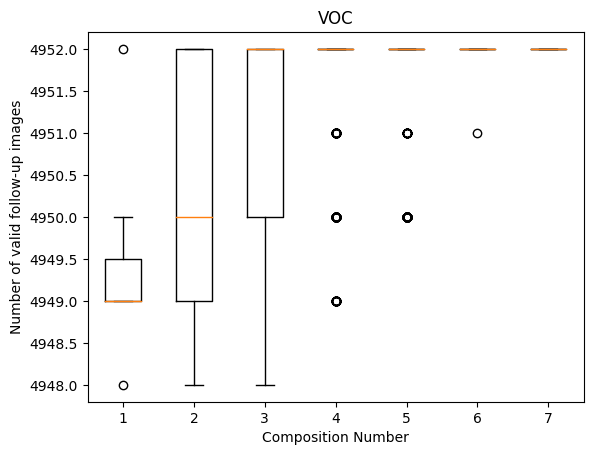

In [4]:
result_selfOracle = np.load('results/SelfOracle/VOC_validity.npy', allow_pickle=True).item()
#print(result_selfOracle)

th = 0.2384941728350421
data = [[] for _ in range(len(mrs))]
for cmr in result_selfOracle.keys():
    data[len(cmr)-1].append(len(np.where(np.array(result_selfOracle[cmr])<=th)[0]))

# 创建箱线图
plt.boxplot(data, patch_artist=False)

# 设置图表标题和轴标签
plt.title('VOC')
plt.xlabel('Composition Number')
plt.ylabel('Number of valid follow-up images')

plt.savefig('results/SelfOracle/VOC_validity.pdf', dpi=600)

# 显示图表
plt.show()
